In [42]:
from ciw.dists import Exponential
from scipy import special, stats
from kmodes.kprototypes import KPrototypes

import ciw
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")

In [24]:
copd = pd.read_csv(
    "/Volumes/thesis-data/copd.csv", parse_dates=["admission_date", "discharge_date"]
)


In [25]:
for col in copd.columns:
    if copd[col].isnull().sum() > .25 * len(copd):
        copd = copd.drop(col, axis=1)

copd = copd.dropna()


In [20]:
unwanted_cols = ["spell_id", "patient_id", "admission_date", "discharge_date"]
data = copd[[col for col in copd if col not in unwanted_cols]].copy()
categorical = [
    i
    for i, (col, dtype) in enumerate(dict(data.dtypes).items())
    if dtype == "object"
]

kp = KPrototypes(n_clusters=4, init="matching", random_state=0)
kp.fit(data, categorical=categorical)

labels = kp.labels_

In [26]:
copd["cluster"] = labels

In [33]:
copd["total_time"] = (copd["discharge_date"] - copd["admission_date"]).dt\
                                                                      .total_seconds()\
                                                                      .div(24 * 60 * 60)

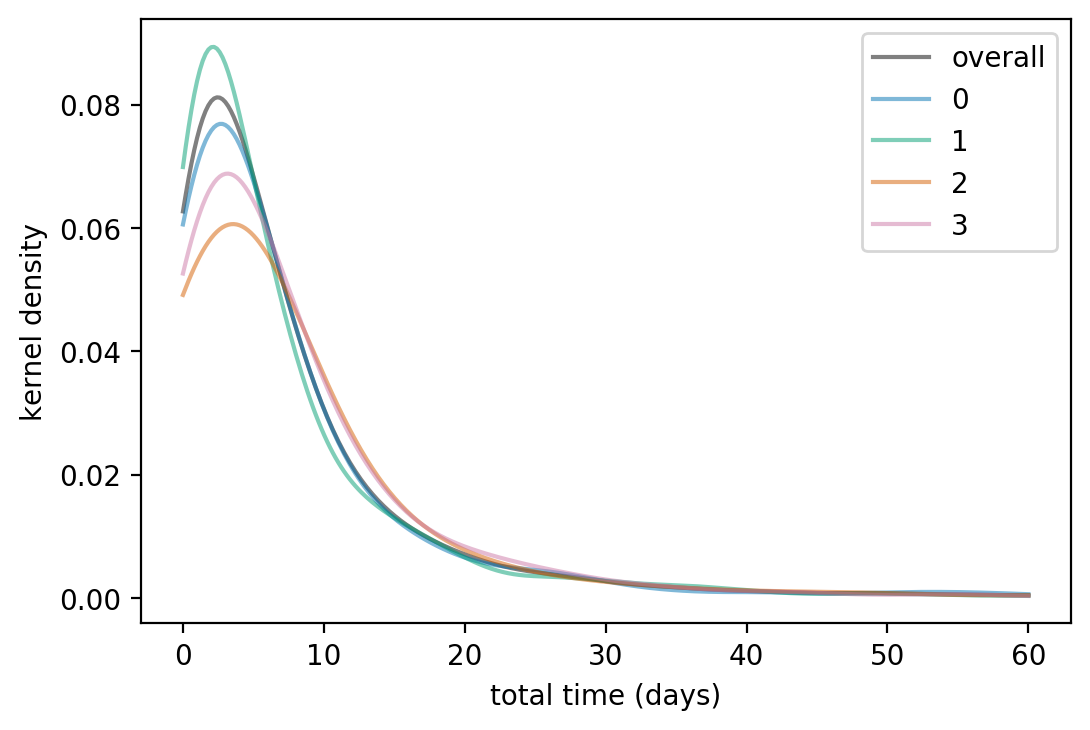

In [44]:
fig, ax = plt.subplots(dpi=200)

xs = np.linspace(0, 60, 300)
kernel = stats.gaussian_kde(copd["total_time"])
ax.plot(xs, kernel(xs), "gray", label="overall")

for cluster, times in copd.groupby("cluster")["total_time"]:

    kernel = stats.gaussian_kde(times)
    ax.plot(xs, kernel(xs), alpha=0.5, label=cluster)

ax.set_xlabel("total time (days)")
ax.set_ylabel("kernel density")

ax.legend()

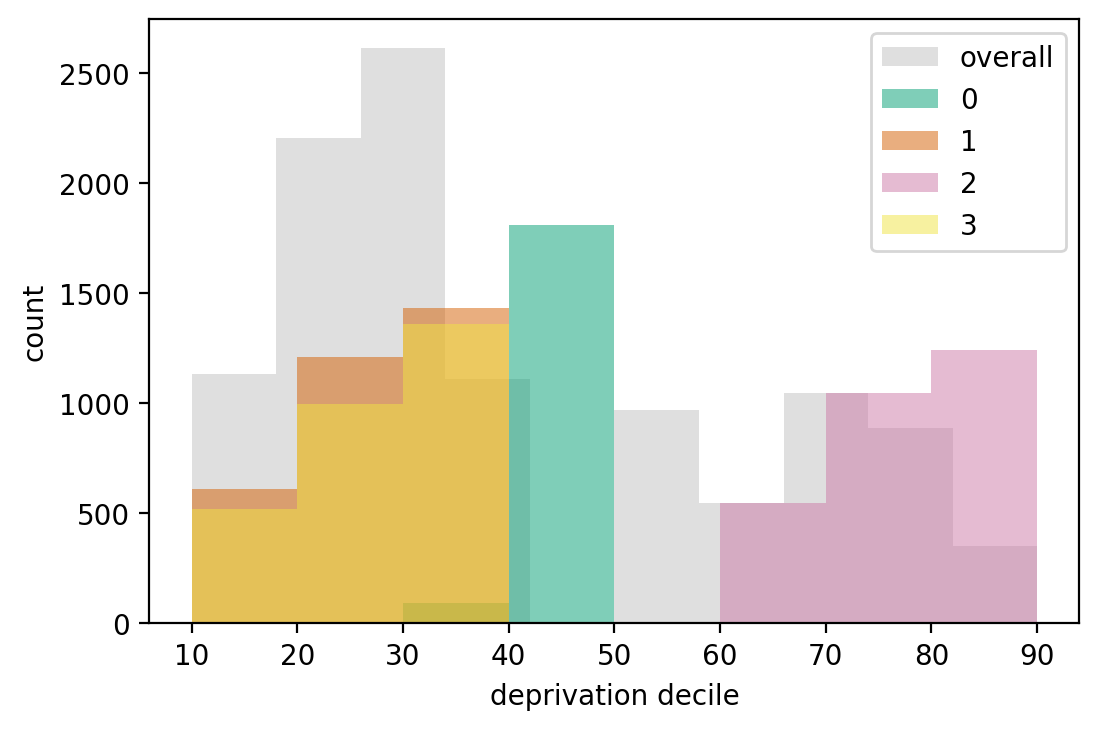

In [70]:
fig, ax = plt.subplots(dpi=200)

ax.hist(copd["deprivation_decile"], bins=10, facecolor="gray", alpha=0.25, label="overall")

for cluster, deprivations in copd.groupby("cluster")["deprivation_decile"]:

    bins = int((max(deprivations) - min(deprivations)) / 10)
    ax.hist(deprivations, bins=bins, alpha=0.5, label=cluster)

ax.set_xlabel("deprivation decile")
ax.set_ylabel("count")

ax.legend()